# Methane Detection and Quantification from Landsat Imagery

This notebook demonstrates how to detect and quantify methane emissions using data from the Landsat 8 and 9 satellites.

The Landsat program, operated by NASA and the US Geological Survey (USGS), provides global multi-spectral imagery with a rich historical archive. Landsat 8 and 9 are the currently active satellites in the series, offering 30-meter spatial resolution across multiple spectral bands, including the shortwave infrared (SWIR) range—crucial for methane detection. Specifically, the SWIR bands (notably Bands 6 and 7) overlap with methane absorption features, allowing us to infer methane concentrations from surface reflectance under favorable conditions. Together, Landsat 8 and 9 provide a temporal resolution of 6-8 days.

In this notebook, we analyze a known emission event at the Korpezhe oil and gas field in Turkmenistan (38.4939°N, 54.1977°E), observed on 2018-09-07. We walk through data preparation, model inference, and the segmentation and quantification of predicted plumes.

In [1]:
import numpy as np
import pandas as pd
import rasterio
import torch
from affine import Affine
from skimage.measure import label
from utils import (
    calculate_major_axis_quantification,
    download_wind_data_from_GEOS_FP,
    get_landsat_band_ratio,
    get_landsat_rgb_bands,
    get_plume_source_location_v2,
    get_wind_speed_for_plume,
    mask_and_segment_plumes,
    plot_band_ratio_timeseries,
    plot_detected_plumes,
    plot_predictions,
    plot_rgb_timeseries,
    plot_segmentation_results,
    predict,
)

## Data Loading and Preprocessing

In this step, we load a preprocessed data stack consisting of Landsat 8/9 imagery centered on our target location. The stack includes one main image from the date of interest and two reference images from nearby dates. All images have been cropped to a 256×256 pixel extent around the source region to reduce data volume for this tutorial. However, the same code can be used to run inference on full Landsat scenes if desired. **Note that steps were taken to ensure the time series stack is spatially aligned**— see [our documentation](https://orbio-earth.github.io/Project-Eucalyptus/Landsat.html#what-are-the-differences-between-the-approach-used-for-Sentinel-2-and-Landsat) for more details on the Landsat tiling system and reprojection process.

Each image contains these bands:
- coastal, blue, green, red, nir08, swir16, swir22, cirrus, lwir11, lwir12, and a data quality mask (qa_pixel, provided by Landsat)

The raw digital number pixel values were converted into reflectance using the formulas provided in https://www.usgs.gov/landsat-missions/using-usgs-landsat-level-1-data-product. [See our docs on why we use reflectance values](https://orbio-earth.github.io/Project-Eucalyptus/Data.html#what-is-the-input-to-the-neural-network). 

The data stack is stored as a Python dictionary with the following format:

```python
data_stack = {
    'main_image': {
        'crop_arrays': np.ndarray,  # shape (n_bands, height, width)
        'bands': List[str],
        'date': str
    },
    'reference_images': [
        {
            'crop_arrays': np.ndarray,
            'bands': List[str],
            'date': str
        },
        {
            'crop_arrays': np.ndarray,
            'bands': List[str],
            'date': str
        }
    ]
}
```

Landsat 8/9 data is publically available via [USGS Landsat AWS Open Data Registry](https://registry.opendata.aws/usgs-landsat/) and various STAC APIs.

**Reference Image Selection Guidelines:**

The model requires reference images to provide temporal context and differentiate persistent features from potential methane plumes. Reference images should meet the following criteria:

1. **Temporal Requirements:** Close in time to the main image
2. **Quality Requirements:** Low cloud/shadow coverage; model performance is best with high-quality references
3. **Spatial Requirements:** Same projection, resolution, band order and cropping as the main image

See [our documentation](https://orbio-earth.github.io/Project-Eucalyptus/Data.html#how-are-reference-scenes-selected?) for more guidance on reference image selection.

In [2]:
data = np.load("resources/landsat/model_input_stack.npy", allow_pickle=True).item()
main_data = data["main_image"]
ref1_data = data["reference_images"][0]
ref2_data = data["reference_images"][1]

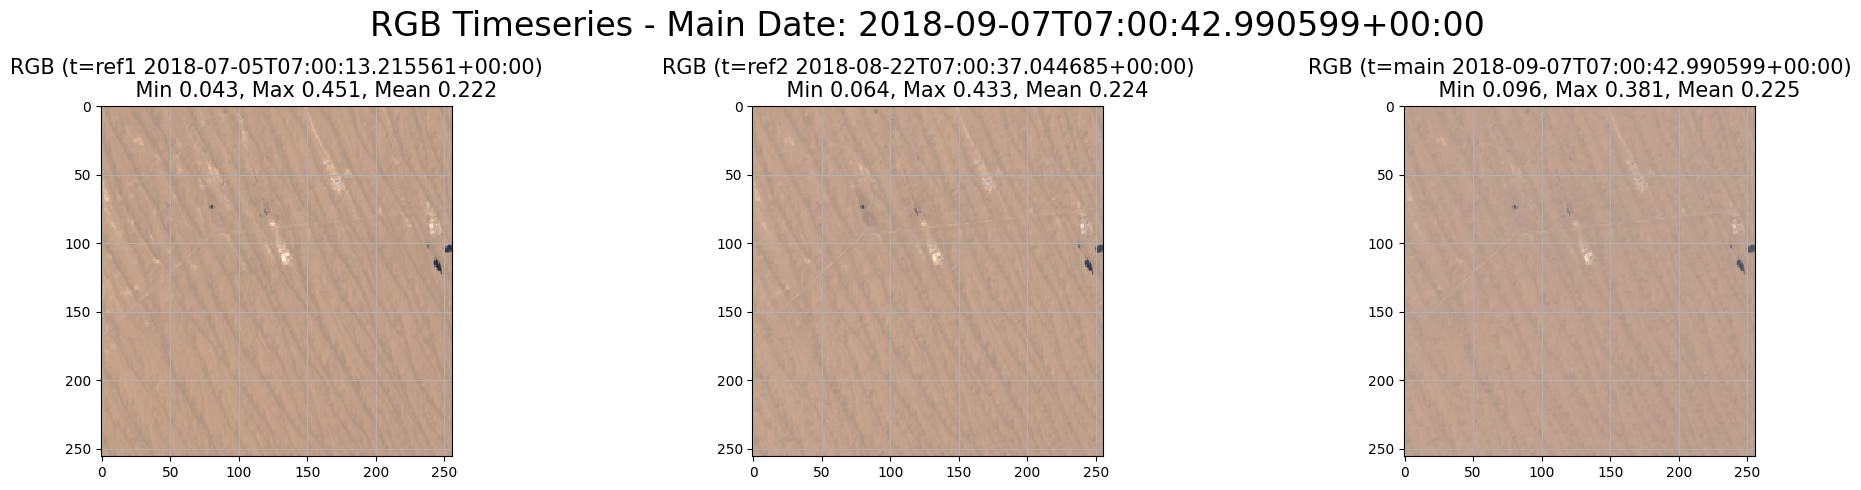

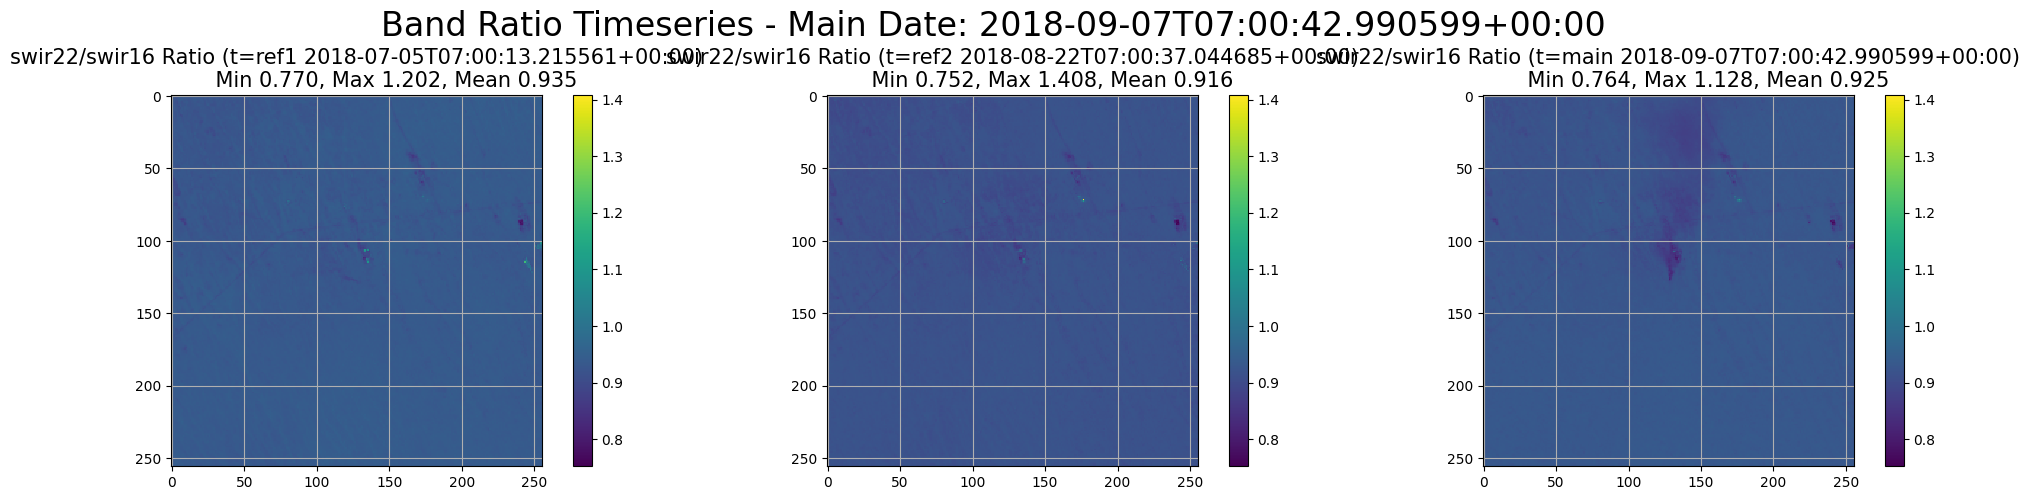

In [3]:
rgb_main = get_landsat_rgb_bands(main_data["crop_arrays"], main_data["bands"])
rgb_ref1 = get_landsat_rgb_bands(ref1_data["crop_arrays"], ref1_data["bands"])
rgb_ref2 = get_landsat_rgb_bands(ref2_data["crop_arrays"], ref2_data["bands"])

ratio_main = get_landsat_band_ratio(main_data["crop_arrays"], main_data["bands"])
ratio_ref1 = get_landsat_band_ratio(ref1_data["crop_arrays"], ref1_data["bands"])
ratio_ref2 = get_landsat_band_ratio(ref2_data["crop_arrays"], ref2_data["bands"])

plot_rgb_timeseries(rgb_main, rgb_ref2, rgb_ref1, main_data["date"], ref2_data["date"], ref1_data["date"])
plot_band_ratio_timeseries(
    ratio_main, ratio_ref2, ratio_ref1, main_data["date"], ref2_data["date"], ref1_data["date"], satellite="landsat"
)

## Preparing Inputs for Inference

The model expects a specific set of bands and temporal arrangement as input. The input tensor is constructed by:

1. **Band Selection:**

- From each reference image: `['swir16', 'swir22', 'nir08', 'red', 'green']`
- From the main image: `['swir16', 'swir22', 'nir08', 'red', 'green']`

These bands were chosen based on their sensitivity to methane absorption and their utility for contextual temporal modeling.

2. **Band Concatenation:**

Bands are concatenated in the following temporal order:

  1. Reference image 1 bands
  2. Main image bands
  3. Reference image 2 bands

This layout allows the model to compare the target image to both its temporal neighbors, helping isolate anomalous changes consistent with methane plumes.

3. **Scaling:**

All bands are scaled by dividing by 10,000. 

The resulting input tensor has shape `(1, n_bands, 256, 256)`, where:

- `1` is the batch dimension
- `n_bands` is the total number of concatenated bands
- `256x256` is the spatial dimensions

In [4]:
def prepare_landsat_model_input(main_data: dict, ref1_data: dict, ref2_data: dict) -> torch.Tensor:
    """
    Transform raw data stack into model input format.

    Args:
        main_data: Dictionary containing main image data
        ref1_data: Dictionary containing first reference image data
        ref2_data: Dictionary containing second reference image data

    Returns:
        torch.Tensor: Transformed input ready for model prediction
    """
    # Define the bands we want to use (depends on the model architecture)
    temporal_bands = ["swir16", "swir22", "nir08", "red", "green"]
    main_bands = ["swir16", "swir22", "nir08", "red", "green"]
    scaling_factor = 1 / 10000

    # Get band indices
    all_bands = main_data["bands"]
    temporal_indices = [all_bands.index(b) for b in temporal_bands]
    main_indices = [all_bands.index(b) for b in main_bands]

    # Extract and concatenate bands in the correct order
    transformed = np.concatenate(
        [
            ref1_data["crop_arrays"][temporal_indices],
            main_data["crop_arrays"][main_indices],
            ref2_data["crop_arrays"][temporal_indices],
        ],
        axis=0,
    )

    # Scale to reflectance
    transformed = transformed * scaling_factor

    # Convert to torch tensor and add batch dimension
    x = torch.from_numpy(transformed).float()[torch.newaxis, ...]

    return x

In [5]:
# Transform data for model input
x = prepare_landsat_model_input(main_data, ref1_data, ref2_data)

## Model Loading and Inference

We use a [U-Net++](https://smp.readthedocs.io/en/latest/models.html#unetplusplus) architecture with a [timm-efficientnet-b1](https://smp.readthedocs.io/en/latest/encoders.html) encoder pretrained on ImageNet.

The model has been trained on synthetic methane plume datasets from Landsat 8/9, using the band combination listed above. For more on the training dataset and methodology, refer to [our docs](https://orbio-earth.github.io/Project-Eucalyptus/Data.html).

### Inference Outputs

The model produces three layers with per-pixel values.
- **likelihood score**: a value in $[0, 1]$ indicating how confident the model is that a pixel contains methane;
- **conditional prediction**: the estimated methane concentration in each pixel; and
- **marginal prediction**: the conditional prediction scaled by the likelihood score.

A full discussion of these layers is provided in our docs [here](https://orbio-earth.github.io/Project-Eucalyptus/Model.html#how-should-the-model-output-be-interpreted).

### Units

The model is trained to predict the **fractional change (frac)** in the swir22/swir16 band ratio relative to a plume-free baseline. Refer to [our docs](https://orbio-earth.github.io/Project-Eucalyptus/Data.html#what-is-the-input-to-the-neural-network) for more details on this. It is used during training and inference but must be post-processed to obtain a gas concentration in mol/m².


In [6]:
model = torch.load("resources/landsat/model.pth", weights_only=False, map_location="cpu")

In [7]:
yhat = predict(model, x)

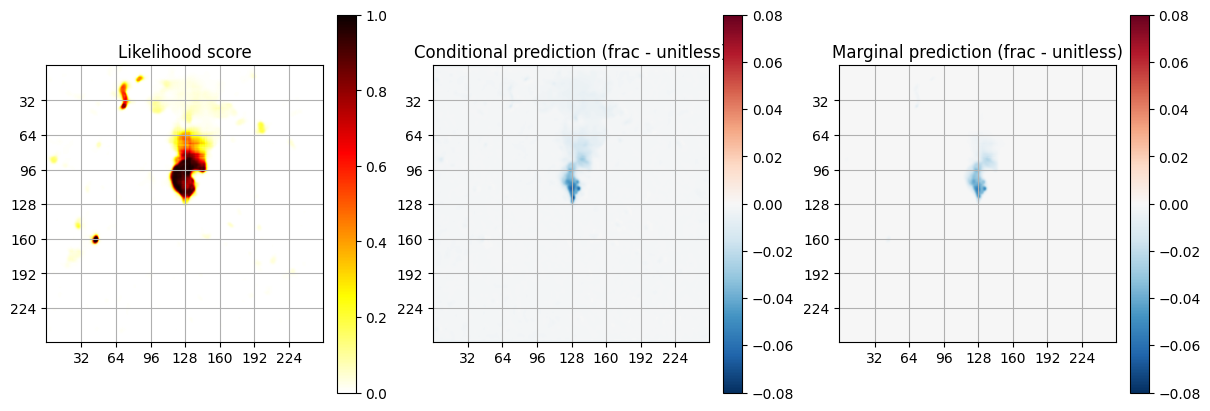

In [8]:
subplot_props = {
    "likelihood": {
        "title": "Likelihood score",
        "imshow_kwargs": {"cmap": "hot_r", "vmin": 0, "vmax": 1},
    },
    "conditional": {
        "title": "Conditional prediction ({units})",
        "imshow_kwargs": {
            "cmap": "RdBu_r",
            "vmin": -0.08,
            "vmax": 0.08,
        },
    },
    "marginal": {
        "title": "Marginal prediction ({units})",
        "imshow_kwargs": {
            "cmap": "RdBu_r",
            "vmin": -0.08,
            "vmax": 0.08,
        },
    },
}

plot_predictions(yhat, subplot_props, units="frac - unitless")

## Mask Plumes

Now that we have the per-pixel methane predictions, the next steps would be to mask and quantify the plumes. Various approaches can be taken for either of these tasks; however, this notebook will only demonstrate our approaches for these. 

To convert the model’s per-pixel predictions into discrete plumes, we apply a Watershed-based segmentation algorithm to the `likelihood` output.

The steps include:
1. Identifying local maxima in the likelihood map
2. Using these maxima as markers for Watershed segmentation
3. Applying a threshold to define the plume footprint
4. Optionally applying morphological closing to fill gaps

This produces a labeled mask where each plume is uniquely indexed. For more details on the masking algorithm, see [our docs](https://orbio-earth.github.io/Project-Eucalyptus/Postprocessing.html#how-are-individual-plumes-masked-(segmented)-out-of-the-inference-output).

In [9]:
marker_distance = 1
marker_threshold = 0.29
watershed_floor_threshold = 0.145
closing_footprint_size = 0

binary_probability = yhat.sel(prediction="likelihood").values

mask, regions = mask_and_segment_plumes(
    binary_probability,
    marker_distance=marker_distance,
    marker_threshold=marker_threshold,
    watershed_floor_threshold=watershed_floor_threshold,
    closing_footprint_size=closing_footprint_size,
)

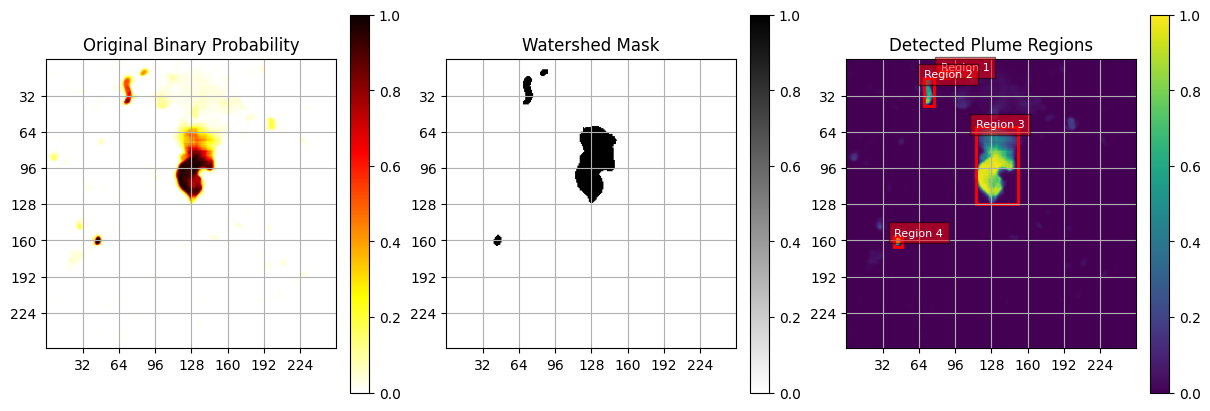

In [10]:
# Define plot properties
subplot_props = {
    "binary_probability": {
        "title": "Original Binary Probability",
        "imshow_kwargs": {"cmap": "hot_r", "vmin": 0, "vmax": 1},
    },
    "watershed_mask": {"title": "Watershed Mask", "imshow_kwargs": {"cmap": "binary", "vmin": 0, "vmax": 1}},
    "regions": {"title": "Detected Plume Regions", "imshow_kwargs": {"cmap": "viridis", "vmin": 0, "vmax": 1}},
}

plot_segmentation_results(binary_probability, mask, regions, subplot_props)

## Quantify 

To estimate the emission rate for each plume, we:

1. **Convert frac values into methane concentraion (mol/m2)**: This notebook doesn't cover the full details of the conversion process. Instead, we use a precomputed lookup table for simplicity. For more information, see [our docs](https://orbio-earth.github.io/Project-Eucalyptus/Radiative_Transfer.html) for more details. **NOTE:** the lookup table here is based on Sentinel-2 data, which is not ideal for Landsat. However, a new lookup table can be created using the Radtran library [here](https://github.com/Orbio-Earth/Eucalyptus-code-archive/blob/main/radtran). The  table is generated using radiative transfer simulations that incorporate instrument spectral responses and gas absorption properties from the HAPI database.
2. **Rescale the retrieval**: See [our docs](https://orbio-earth.github.io/Project-Eucalyptus/Postprocessing.html#why-do-you-use-the-rescaled-retrieval–for-quantification) for the reasoning behind this
3. **Estimate the plume source location** using the maximum value in the `plume_retrieval`
4. **Retrieve effective wind speed** at the source location from a wind dataset (we use GEOS-FP)
5. **Apply the major axis method**: estimate the emission rate as the ratio of Integrated Methane Enhancement (IME) to plume length, scaled by the effective wind speed. This method fits a minimum rotated rectangle to the plume mask and uses its longest side as the length estimate. For full details, see [our quantification method guide](https://orbio-earth.github.io/Project-Eucalyptus/Postprocessing.html#how-do-you-estimate-the-emissions-rate-for-a-plume).

In [11]:
pixel_width = 30.0  # Because Landsat has 30m resolution

# Get wind data for the main image
wind_ds = download_wind_data_from_GEOS_FP(main_data["date"])

# Get CRS and transform from the main image from its tiff file
with rasterio.open("resources/landsat/main_image_B7.TIF") as src:
    crs = src.crs
    transform = src.transform

url='https://portal.nccs.nasa.gov/datashare/gmao/geos-fp/das/Y2018/M09/D07/GEOS.fp.asm.inst3_2d_asm_Nx.20180907_0600.V01.nc4'


In [12]:
# Convert from frac to retrieval in mol/m2
conditional_frac = yhat.sel(prediction="conditional").values
radtran_lookup_table = pd.read_csv("resources/s2/radtran_lookup_table.csv")
# We're eliding over a lot of details here. The radtran lookup table has been pre-computed
# for Sentinel 2A under certain atmospheric assumptions, and assuming the sun and the instrument
# are at zenith. This needs to be compensated by the actual path length of light
# through the atmosphere, which we won't do here.
conditional_retrieval = np.interp(-conditional_frac, -radtran_lookup_table.frac, radtran_lookup_table.ch4)

# The marginal retrieval is the probability-weighted conditional retrieval
marginal_retrieval = conditional_retrieval * binary_probability

# Label the binary mask
labeled_mask = label(mask, connectivity=2)

# Quantify each plume
plumes = []

for region in regions:
    label_id = region.label

    # Get bounding box
    min_row, min_col, max_row, max_col = region.bbox

    plume_max_probability = np.max(binary_probability[labeled_mask == label_id])

    # Extract localized mask and retrieval
    region_mask = labeled_mask[min_row:max_row, min_col:max_col]
    plume_mask = region_mask == label_id
    marginal_retrieval_slice = marginal_retrieval[min_row:max_row, min_col:max_col]

    # We rescale by the maximum probability within the plume to get a
    # retrieval assuming this is a true plume.
    rescaled_retrieval_slice = marginal_retrieval_slice / plume_max_probability

    # Compute transform for cropped region
    local_transform = transform * Affine.translation(min_col, min_row)

    # Compute plume data and source location directly
    plume_data = rescaled_retrieval_slice * plume_mask
    lat, lon = get_plume_source_location_v2(plume_data, crs, local_transform)

    # Get wind data at source
    u_eff, u_eff_high, u_eff_low, wind_direction, u10 = get_wind_speed_for_plume(wind_ds, lat, lon)

    # Quantify plume using major axis method
    length, IME, Q = calculate_major_axis_quantification(plume_mask, rescaled_retrieval_slice, pixel_width, u_eff)
    _, _, Q_low = calculate_major_axis_quantification(plume_mask, rescaled_retrieval_slice, pixel_width, u_eff_low)
    _, _, Q_high = calculate_major_axis_quantification(plume_mask, rescaled_retrieval_slice, pixel_width, u_eff_high)

    # Store result
    plumes.append(
        {
            "label": label_id,
            "source_location": (lat, lon),
            "length": length,
            "IME": IME,
            "Q": Q,
            "Q_low": Q_low,
            "Q_high": Q_high,
            "wind_direction": wind_direction,
            "u10_wind": u10,
            "u_eff": u_eff,
            "bbox": region.bbox,
            "likelihood_score": plume_max_probability,
        }
    )

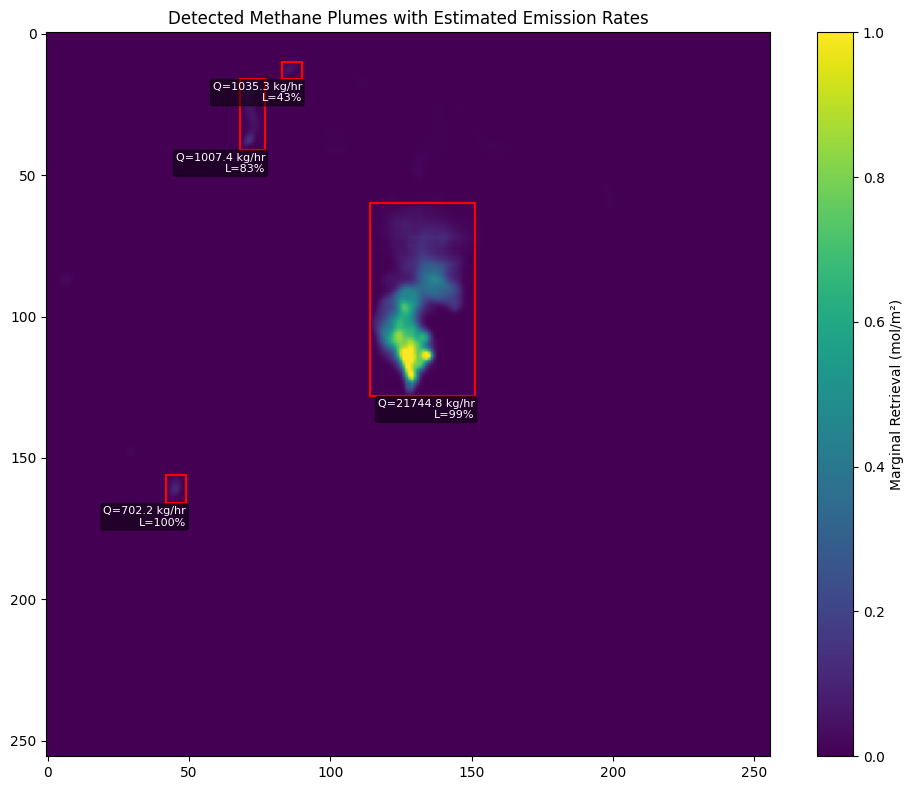

In [13]:
plot_detected_plumes(marginal_retrieval=marginal_retrieval, plumes=plumes)